<a href="https://colab.research.google.com/github/drawoliver/FitDSFCurves/blob/main/FitDSFCurves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FitDSFCurves**







**A python jiffy to fit DSF data with a modified Boltzmann equation to determine a value for Tm and slope.**

Run the first cell to install lmfit and seaborn packages.

Note: you only need to do this once to 'intialise' the program.

In [ ]:
#@title Initialisation

# Run once initialisation (lmfit, seaborn)
%pip install lmfit
%pip install seaborn

The next cell imports various packages needed to run the program.

In [ ]:
#@title Load Dependancies

# Setup requirements
import io
import math
import pandas as pd
import numpy as np
import sympy
import matplotlib.pyplot as plt
import seaborn as sns
import lmfit
from scipy.optimize import curve_fit
from google.colab import files
from google.colab import output

Run the next cell — click on "Choose files" to select and upload a .csv format file.

Note 1: this expects the Temperature data to be in the first column followed by data for individual melting curves as you wish to fit.

Note 2: the program will report both the individual Tm / slope values for each melting curve, plus the average across ALL melting curves.

In [ ]:
#@title Load .csv File

# Upload .csv file and eliminate NaN and column headers
uploaded = files.upload()


Saving DSF3.csv to DSF3 (2).csv


The next cell uploads the .csv file, drops the headers and removes any stray NaN values.

In [2]:
#@title Cleanup .csv File

# Upload .csv file, drop headers and remove NaN values
filename = next(iter(uploaded))
data = pd.read_csv(filename, header=None, skiprows=1)
data = data.dropna(axis='rows')

NameError: ignored

The next cell does the curve fitting for each individual dataset and plots a graph.


Data in column 1 converged after 3 iterations.


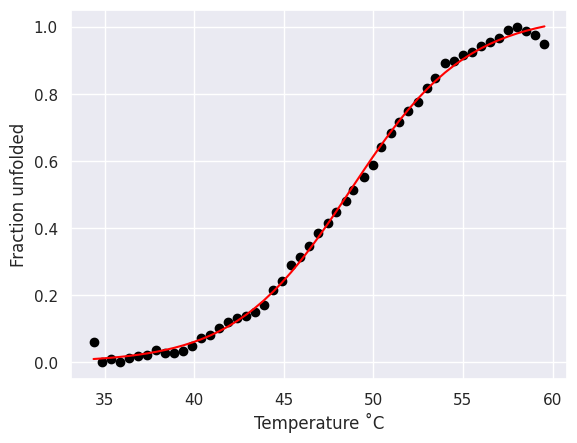

Fitted Values:
Tm: 48.68936340557496
Slope: 3.2378007609474833

Data in column 2 converged after 3 iterations.


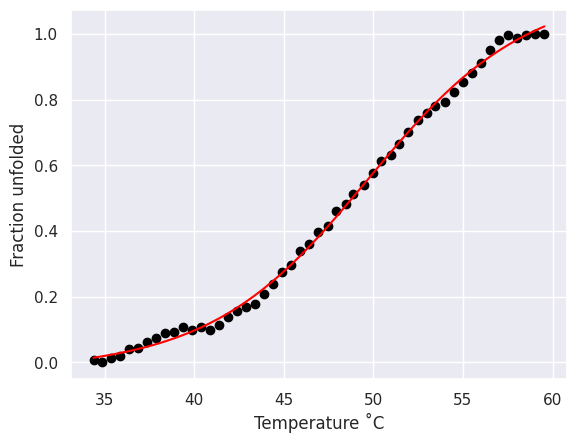

Fitted Values:
Tm: 49.647994393106885
Slope: 4.309497364197283

Data in column 3 converged after 2 iterations.


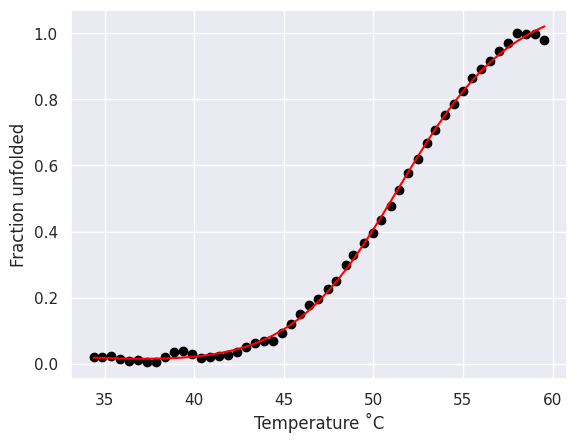

Fitted Values:
Tm: 51.2654560653763
Slope: 3.0982396633167815

Data in column 4 converged after 2 iterations.


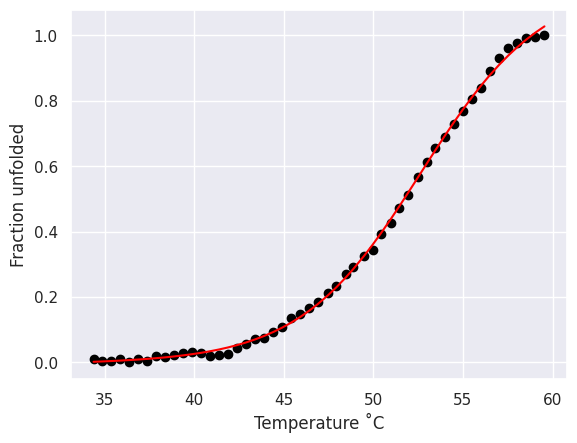

Fitted Values:
Tm: 52.563996171055805
Slope: 3.337180251522065



In [ ]:
#@title Fit and Plot Data

# Create x and y-data variables from uploaded .csv file (y_data1 for column 1, y_data2 for column2 etc)
num_columns = len(data.columns)
x_data = data.iloc[:, 0]

for i in range(1, num_columns):
    globals()[f"y_data{i}"] = data.iloc[:, i]


# Equation for fitting data
def user_defined_equation_1(x, slope_native, intercept_native, slope_denatured, intercept_denatured, melting_temp, slope_midpoint):
  return ((slope_native * x + intercept_native) + (((slope_denatured * x + intercept_denatured)-(slope_native * x + intercept_native)/(1 + (np.exp((melting_temp - x) / slope_midpoint))))))

# Number of iterations
max_iterations = 1000

# Set initial guess
initial_guess = [0,0,0,1,35,2]

# Perform iterative fitting with Levenberg-Marquardt

for i in range (1, num_columns):

  input_y_data = globals()[f"y_data{i}"]

  for iteration in range(max_iterations):

    # Use curve_fit with the current initial guess and 'lm' method
    fit_params, covariance = curve_fit(user_defined_equation_1, x_data, input_y_data, p0=initial_guess, method='trf', bounds=((-np.inf,-np.inf,-np.inf,0.99,20,-np.inf), (np.inf,np.inf,np.inf,1.0,120,np.inf)) )
    # Generate fitted y values using the fitted parameters
    y_fit = user_defined_equation_1(x_data, *fit_params)

    # Check for convergence (you can customize this condition based on your needs)
    if np.all(np.abs(np.array(initial_guess) - np.array(fit_params)) < 1e-6):
        print(f'Data in column {i} converged after {iteration + 1} iterations.')
        break

    # Update initial guess for the next iteration
    initial_guess = fit_params

  globals()[f"Tm_column{i}"] = fit_params[4]
  globals()[f"Slope_column{i}"] = fit_params[5]

  # Initialize plot
  sns.set_theme()
  fig, ax = plt.subplots()
  # Plot data
  ax.scatter(x_data, input_y_data, label='Data', color='black')
  plt.xlabel('Temperature ˚C')
  plt.ylabel('Fraction unfolded')
  ax.plot(x_data, y_fit, color='red')
  plt.show()

  # Print the final values for each parameter
  print("Fitted Values:")
  print("Tm:",fit_params[4])
  print("Slope:",fit_params[5])
  print ("")
  #print("Native slope:",fit_params[0])
  #print("Native intercept:",fit_params[1])
  #print("Denatured slope:",fit_params[2])
  #print("Denatured intercept", fit_params[3])




The next cell creates a short summary for the fitted data and reports average values (valid only if the input data represent experimental replicates).

In [ ]:
#@title Create Summary

# Create Summary
sum_tm = 0

for i in range (1, num_columns):
  result_float = round(float(globals()[f"Tm_column{i}"]),2)
  print("Tm for column",i,":", result_float)
  sum_tm = sum_tm + result_float

average_tm = sum_tm / (num_columns-1)
result_average_tm = round(average_tm, 2)
print("Average Tm:", result_average_tm)

print("")

sum_slope = 0

for i in range (1, num_columns):
  result_float = round(float(globals()[f"Slope_column{i}"]),2)
  print("Slope for column",i,":", result_float)
  sum_slope = sum_slope + result_float

average_slope = sum_slope / (num_columns-1)
result_average_slope = round(average_slope,2)
print ("Average Slope:", result_average_slope)


Tm for column 1 : 48.69
Tm for column 2 : 49.65
Tm for column 3 : 51.27
Tm for column 4 : 52.56
Average Tm: 50.54

Slope for column 1 : 3.24
Slope for column 2 : 4.31
Slope for column 3 : 3.1
Slope for column 4 : 3.34
Average Slope: 3.5
